Transect Calculation

This is a demonstration script of how to create transects from the data.

It uses Transect class in the COAsT package. This object has strict data formatting requirements, which are outlined in tranect.py.  
    _**Transect subsetting** (a vertical slice of data between two coordinates): Creating them and performing some custom diagnostics with them._  

In this tutorial we take a look at subsetting the model data along a transect (a custom straight line) and creating some bespoke diagnostics along it. We look at:

    1. Creating a TRANSECT object, defined between two points.
    2. Plotting data along a transect.
    3. Calculating flow normal to the transect

### Import relevant packages

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [18]:
import coast
import xarray as xr
import matplotlib.pyplot as plt

### Define filepaths for data and configuration

In [19]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly/1950"
fn_nemo_grid_t_dat = f"{data_path}/cv575o_1_mon__grid_T_votemper.nc"
fn_nemo_dat_u = f"{data_path}/cv575o_1_mon__grid_U_vozocrtx.nc"
fn_nemo_dat_v = f"{data_path}/cv575o_1_mon__grid_V_vomecrty.nc"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"

fn_nemo_grid_t_dat_sal = f"{data_path}/cv575o_1_mon__grid_T_vosaline.nc"
fn_config_t_grid = "../../config/example_nemo_grid_t.json"
fn_config_f_grid = "../../config/example_nemo_grid_f.json"
fn_config_u_grid = "../../config/example_nemo_grid_u.json"
fn_config_v_grid = "../../config/example_nemo_grid_v.json"

### Load data variables that are on the NEMO t-grid

In [5]:
Tdata = xr.open_mfdataset(fn_nemo_grid_t_dat)

In [6]:
nemo_t = coast.Gridded(fn_data=Tdata, fn_domain=fn_nemo_dom, config=fn_config_t_grid)

### Now create a transect using the `coast.TransectT` object. 
The transect is between the points (54 N 15 W) and (56 N, 12 W). This needs to be passed the corresponding NEMO object and transect end points. The model points closest to these coordinates will be selected as the transect end points.


In [7]:
tran_t = coast.TransectT(nemo_t, (54, -15), (56, -12))

# Inspect the data
# tran_t.data # uncomment to print data object summary

### Plot the data

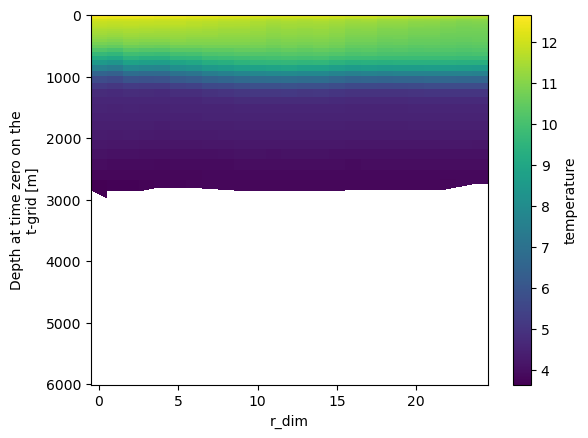

In [8]:
# It is simple to plot a scalar such as temperature along the transect:
temp_mean = tran_t.data.temperature.mean(dim="t_dim")
plt.figure()
temp_mean.plot.pcolormesh(y="depth_0", yincrease=False)
plt.show()

### Create a nemo f-grid object
With NEMO’s staggered grid, the first step is to define the transect on the f-grid so that the velocity components are between f-points. We do not need any model data on the f-grid, just the grid information, so create a nemo f-grid object


In [9]:
nemo_f = coast.Gridded(fn_domain=fn_nemo_dom, config=fn_config_f_grid)

### Transect on the f-grid

In [10]:
tran_f = coast.TransectF(nemo_f, (54, -15), (56, -12))
# Inspect the data
#tran_f.data # uncomment to print data object summary

### Load model data on the u- and v- grids

In [17]:
t_data_u = xr.open_mfdataset(fn_nemo_dat_u)
nemo_u = coast.Gridded(fn_data=t_data_u, fn_domain=fn_nemo_dom, config=fn_config_u_grid)

In [20]:
t_data_v = xr.open_mfdataset(fn_nemo_dat_v)
nemo_v = coast.Gridded(fn_data=t_data_v, fn_domain=fn_nemo_dom, config=fn_config_v_grid)

### Calculate the flow across the transect

In [23]:
tran_f.calc_flow_across_transect(nemo_u, nemo_v)

# The flow across the transect is stored in a new dataset where the variables are all defined at the points between f-points.
#tran_f.data_cross_tran_flow # uncomment to print data object summary

### Plot the time averaged velocity across the transect

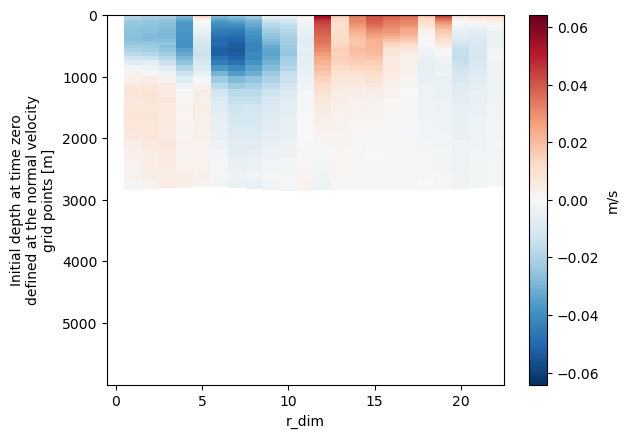

In [24]:
# To do this we can plot the ‘normal_velocities’ variable.
cross_velocity_mean = tran_f.data_cross_tran_flow.normal_velocities.mean(dim="t_dim")
plt.figure()
cross_velocity_mean.rolling(r_dim=2).mean().plot.pcolormesh(yincrease=False, y="depth_0", cbar_kwargs={"label": "m/s"})
plt.show()

### Plot volume transport across the transect

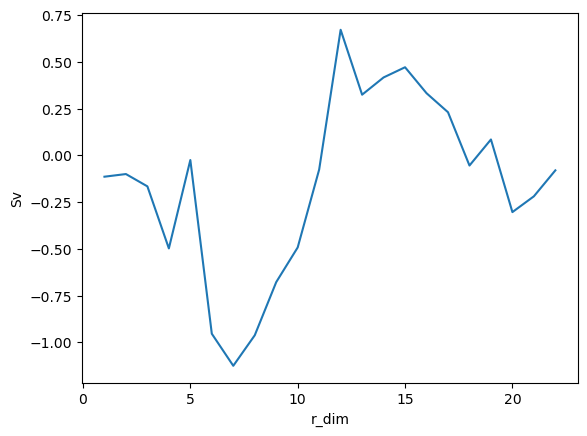

In [25]:
# To do this we can plot the ‘normal_transports’ variable.
plt.figure()
cross_transport_mean = tran_f.data_cross_tran_flow.normal_transports.mean(dim="t_dim")
cross_transport_mean.rolling(r_dim=2).mean().plot()
plt.ylabel("Sv")
plt.show()